##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Build, train and evaluate models with TensorFlow Decision Forests

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/beginner_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/beginner_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/beginner_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/beginner_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


## Introduction

Decision Forests (DF) are a large family of Machine Learning algorithms for
supervised classification, regression and ranking. As the name suggests, DFs use
decision trees as a building block. Today, the two most popular DF training
algorithms are [Random Forests](https://en.wikipedia.org/wiki/Random_forest) and
[Gradient Boosted Decision Trees](https://en.wikipedia.org/wiki/Gradient_boosting). Both algorithms are ensemble techniques that use multiple decision trees, but differ on how they do it.

TensorFlow Decision Forests (TF-DF) is a library for the training,
evaluation, interpretation and inference of Decision Forest models.

In this tutorial, you will learn how to:

1.  Train a binary classification Random Forest on a dataset containing numerical, categorical and missing features.
1.  Evaluate the model on a test dataset.
1.  Prepare the model for
    [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).
1.  Examine the overall structure of the model and the importance of each feature.
1.  Re-train the model with a different learning algorithm (Gradient Boosted Decision Trees).
1.  Use a different set of input features.
1.  Change the hyperparameters of the model.
1.  Preprocess the features.
1.  Train a model for regression.
1.  Train a model for ranking.

Detailed documentation is available in the [user manual](https://github.com/tensorflow/decision-forests/documentation).
The [example directory](https://github.com/tensorflow/decision-forests/examples) contains other end-to-end examples.

## Installing TensorFlow Decision Forests

Install TF-DF by running the following cell.

In [2]:
!pip install tensorflow_decision_forests

  Using cached tensorflow_decision_forests-0.2.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (17.1 MB)


Install [Wurlitzer](https://pypi.org/project/wurlitzer/) to display
the detailed training logs. This is only needed in colabs.

In [3]:
!pip install wurlitzer

## Importing libraries

In [4]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

try:
  from wurlitzer import sys_pipes
except:
  from colabtools.googlelog import CaptureLog as sys_pipes

from IPython.core.magic import register_line_magic
from IPython.display import Javascript

The hidden code cell limits the output height in colab.


In [5]:
#@title

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [6]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v0.2.1


## Training a Random Forest model

In this section, we train, evaluate, analyse and export a binary classification Random Forest trained on the [Palmer's Penguins](https://allisonhorst.github.io/palmerpenguins/articles/intro.html) dataset.

<center>
<img src="https://allisonhorst.github.io/palmerpenguins/man/figures/palmerpenguins.png" width="150"/></center>

**Note:** The dataset was exported to a csv file without pre-processing: `library(palmerpenguins); write.csv(penguins, file="penguins.csv", quote=F, row.names=F)`. 

### Load the dataset and convert it in a tf.Dataset

This dataset is very small (300 examples) and stored as a .csv-like file. Therefore, use Pandas to load it.

**Note:** Pandas is practical as you don't have to type in name of the input features to load them. For larger datasets (>1M examples), using the
[TensorFlow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to read the files may be better suited.

Let's assemble the dataset into a csv file (i.e. add the header), and load it:

In [7]:
# Download the dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("/tmp/penguins.csv")

# Display the first 3 examples.
dataset_df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


The dataset contains a mix of numerical (e.g. `bill_depth_mm`), categorical
(e.g. `island`) and missing features. TF-DF supports all these feature types natively (differently than NN based models), therefore there is no need for preprocessing in the form of one-hot encoding, normalization or extra `is_present` feature.

Labels are a bit different: Keras metrics expect integers. The label (`species`) is stored as a string, so let's convert it into an integer.

In [8]:
# Encode the categorical label into an integer.
#
# Details:
# This stage is necessary if your classification label is represented as a
# string. Note: Keras expected classification labels to be integers.

# Name of the label column.
label = "species"

classes = dataset_df[label].unique().tolist()
print(f"Label classes: {classes}")

dataset_df[label] = dataset_df[label].map(classes.index)

Label classes: ['Adelie', 'Gentoo', 'Chinstrap']


Next split the dataset into training and testing:

In [9]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

252 examples in training, 92 examples for testing.


And finally, convert the pandas dataframe (`pd.Dataframe`) into tensorflow datasets (`tf.data.Dataset`):

In [10]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core.py:1612: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


**Notes:** `pd_dataframe_to_tf_dataset` could have converted the label to integer for you.

And, if you wanted to create the `tf.data.Dataset` yourself, there is a couple of things to remember:

- The learning algorithms work with a one-epoch dataset and without shuffling.
- The batch size does not impact the training algorithm, but a small value might slow down reading the dataset.


### Train the model

In [11]:
%set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel()

# Optionally, add evaluation metrics.
model_1.compile(
    metrics=["accuracy"])

# Train the model.
# "sys_pipes" is optional. It enables the display of the training logs.
with sys_pipes():
  model_1.fit(x=train_ds)

<IPython.core.display.Javascript object>

1/4 [======>.......................] - ETA: 12s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4
[INFO kernel.cc:393] Number of examples: 252
[INFO kernel.cc:759] Dataset:
Number of records: 252
Number of columns: 8

Number of columns by type:
	NUMERICAL: 5 (62.5%)
	CATEGORICAL: 3 (37.5%)

Columns:

NUMERICAL: 5 (62.5%)
	0: "bill_depth_mm" NUMERICAL num-nas:2 (0.793651%) mean:17.1936 min:13.2 max:21.5 sd:1.96763
	1: "bill_length_mm" NUMERICAL num-nas:2 (0.793651%) mean:44.1884 min:33.1 max:59.6 sd:5.36528
	2: "body_mass_g" NUMERICAL num-nas:2 (0.793651%) mean:4221 min:2700 max:6300 sd:811.125
	3: "flipper_length_mm" NUMERICAL num-nas:2 (0.793651%) mean:201.264 min:172 max:231 sd:14.0793
	6: "year" NUMERICAL mean:2008.05 min:2007 max:2009 sd:0.817297

CATEGORICAL: 3 (37.5%)
	4: "island" CATEGORICAL has-dict vocab-size:4 zero-ood-items most-frequent:"Biscoe" 126 (50%)
	5: "sex" CATEGORICAL num-nas:7 (2.77778%) has-dict vocab-size:3 zero-ood-ite

learner: "RANDOM_FOREST"
features: "bill_depth_mm"
features: "bill_length_mm"
features: "body_mass_g"
features: "flipper_length_mm"
features: "island"
features: "sex"
features: "year"
label: "__LABEL"
task: CLASSIFICATION
[yggdrasil_decision_forests.model.random_forest.proto.random_forest_config] {
  num_trees: 300
  decision_tree {
    max_depth: 16
    min_examples: 5
    in_split_min_examples_check: true
    missing_value_policy: GLOBAL_IMPUTATION
    allow_na_conditions: false
    categorical_set_greedy_forward {
      sampling: 0.1
      max_num_items: -1
      min_item_frequency: 1
    }
    growing_strategy_local {
    }
    categorical {
      cart {
      }
    }
    num_candidate_attributes_ratio: -1
    axis_aligned_split {
    }
    internal {
      sorting_strategy: PRESORTED
    }
  }
  winner_take_all_inference: true
  compute_oob_performances: true
  compute_oob_variable_importances: false
  adapt_bootstrap_size_ratio_for_maximum_training_duration: false
}

[INFO kernel

[INFO random_forest.cc:628] Training of tree  1/300 (tree index:0) done accuracy:0.922222 logloss:2.8034


[INFO random_forest.cc:628] Training of tree  11/300 (tree index:10) done accuracy:0.960159 logloss:0.355553
[INFO random_forest.cc:628] Training of tree  21/300 (tree index:17) done accuracy:0.960317 logloss:0.360011
[INFO random_forest.cc:628] Training of tree  31/300 (tree index:32) done accuracy:0.968254 logloss:0.355906
[INFO random_forest.cc:628] Training of tree  41/300 (tree index:41) done accuracy:0.972222 logloss:0.354263
[INFO random_forest.cc:628] Training of tree  51/300 (tree index:51) done accuracy:0.980159 logloss:0.355675
[INFO random_forest.cc:628] Training of tree  61/300 (tree index:60) done accuracy:0.97619 logloss:0.354058
[INFO random_forest.cc:628] Training of tree  71/300 (tree index:70) done accuracy:0.972222 logloss:0.355711
[INFO random_forest.cc:628] Training of tree  81/300 (tree index:82) done accuracy:0.980159 logloss:0.356747


[INFO random_forest.cc:628] Training of tree  91/300 (tree index:90) done accuracy:0.97619 logloss:0.225018
[INFO random_forest.cc:628] Training of tree  101/300 (tree index:100) done accuracy:0.972222 logloss:0.221976
[INFO random_forest.cc:628] Training of tree  111/300 (tree index:109) done accuracy:0.972222 logloss:0.223525


[INFO random_forest.cc:628] Training of tree  121/300 (tree index:117) done accuracy:0.972222 logloss:0.095911
[INFO random_forest.cc:628] Training of tree  131/300 (tree index:127) done accuracy:0.968254 logloss:0.0970941


[INFO random_forest.cc:628] Training of tree  141/300 (tree index:140) done accuracy:0.972222 logloss:0.0962378
[INFO random_forest.cc:628] Training of tree  151/300 (tree index:151) done accuracy:0.972222 logloss:0.0952778
[INFO random_forest.cc:628] Training of tree  161/300 (tree index:161) done accuracy:0.97619 logloss:0.0953929
[INFO random_forest.cc:628] Training of tree  171/300 (tree index:172) done accuracy:0.972222 logloss:0.0966406


[INFO random_forest.cc:628] Training of tree  181/300 (tree index:180) done accuracy:0.97619 logloss:0.096802
[INFO random_forest.cc:628] Training of tree  191/300 (tree index:189) done accuracy:0.972222 logloss:0.0952902
[INFO random_forest.cc:628] Training of tree  201/300 (tree index:200) done accuracy:0.972222 logloss:0.0926996
[INFO random_forest.cc:628] Training of tree  211/300 (tree index:210) done accuracy:0.97619 logloss:0.0923645


[INFO random_forest.cc:628] Training of tree  221/300 (tree index:221) done accuracy:0.97619 logloss:0.0928984
[INFO random_forest.cc:628] Training of tree  231/300 (tree index:230) done accuracy:0.97619 logloss:0.0938896
[INFO random_forest.cc:628] Training of tree  241/300 (tree index:240) done accuracy:0.972222 logloss:0.0947512
[INFO random_forest.cc:628] Training of tree  251/300 (tree index:250) done accuracy:0.972222 logloss:0.0952597


[INFO random_forest.cc:628] Training of tree  261/300 (tree index:260) done accuracy:0.972222 logloss:0.0948972


[INFO random_forest.cc:628] Training of tree  271/300 (tree index:270) done accuracy:0.968254 logloss:0.096022


[INFO random_forest.cc:628] Training of tree  281/300 (tree index:280) done accuracy:0.968254 logloss:0.0950604


[INFO random_forest.cc:628] Training of tree  291/300 (tree index:290) done accuracy:0.972222 logloss:0.0962781
[INFO random_forest.cc:628] Training of tree  300/300 (tree index:298) done accuracy:0.972222 logloss:0.0967387
[INFO random_forest.cc:696] Final OOB metrics: accuracy:0.972222 logloss:0.0967387


[INFO kernel.cc:828] Export model in log directory: /tmp/tmpdqbqx3ck


[INFO kernel.cc:836] Save model in resources


[INFO kernel.cc:988] Loading model from path


[INFO decision_forest.cc:590] Model loaded with 300 root(s), 4558 node(s), and 7 input feature(s).
[INFO abstract_model.cc:993] Engine "RandomForestGeneric" built
[INFO kernel.cc:848] Use fast generic engine


4/4 [==============================] - 4s 19ms/step


### Remarks

-   No input features are specified. Therefore, all the columns will be used as
    input features except for the label. The feature used by the model are shown
    in the training logs and in the `model.summary()`.
-   DFs consume natively numerical, categorical, categorical-set features and
    missing-values. Numerical features do not need to be normalized. Categorical
    string values do not need to be encoded in a dictionary.
-   No training hyper-parameters are specified. Therefore the default
    hyper-parameters will be used. Default hyper-parameters provide
    reasonable results in most situations.
-   Calling `compile` on the model before the `fit` is optional. Compile can be
    used to provide extra evaluation metrics.
-   Training algorithms do not need validation datasets. If a validation dataset
    is provided, it will only be used to show metrics.

**Note:** A *Categorical-Set* feature is composed of a set of categorical values (while a *Categorical* is only one value). More details and examples are given later.

## Evaluate the model

Let's evaluate our model on the test dataset.

In [12]:
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/2 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000

2/2 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 1.0000



loss: 0.0000
accuracy: 1.0000


**Remark:** The test accuracy (0.86514) is close to the Out-of-bag accuracy
(0.8672) shown in the training logs.

See the **Model Self Evaluation** section below for more evaluation methods.

## Prepare this model for TensorFlow Serving.

Export the model to the SavedModel format for later re-use e.g.
[TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).


In [13]:
model_1.save("/tmp/my_saved_model")

2021-11-08 12:10:07.057561: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/my_saved_model/assets


INFO:tensorflow:Assets written to: /tmp/my_saved_model/assets


## Plot the model

Plotting a decision tree and following the first branches helps learning about decision forests. In some cases, plotting a model can even be used for debugging.

Because of the difference in the way they are trained, some models are more interresting to plan than others. Because of the noise injected during training and the depth of the trees, plotting Random Forest is less informative than plotting a CART or the first tree of a Gradient Boosted Tree.

Never the less, let's plot the first tree of our Random Forest model:

In [14]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

The root node on the left contains the first condition (`bill_depth_mm >= 16.55`), number of examples (240) and label distribution (the red-blue-green bar).

Examples that evaluates true to `bill_depth_mm >= 16.55` are branched to the green path. The other ones are branched to the red path.

The deeper the node, the more `pure` they become i.e. the label distribution is biased toward a subset of classes. 

**Note:** Over the mouse on top of the plot for details.

## Model tructure and feature importance

The overall structure of the model is show with `.summary()`. You will see:

-   **Type**: The learning algorithm used to train the model (`Random Forest` in
    our case).
-   **Task**: The problem solved by the model (`Classification` in our case).
-   **Input Features**: The input features of the model.
-   **Variable Importance**: Different measures of the importance of each
    feature for the model.
-   **Out-of-bag evaluation**: The out-of-bag evaluation of the model. This is a
    cheap and efficient alternative to cross-validation.
-   **Number of {trees, nodes} and other metrics**: Statistics about the
    structure of the decisions forests.

**Remark:** The summary's content depends on the learning algorithm (e.g.
Out-of-bag is only available for Random Forest) and the hyper-parameters (e.g.
the *mean-decrease-in-accuracy* variable importance can be disabled in the
hyper-parameters).

In [15]:
%set_cell_height 300
model_1.summary()

<IPython.core.display.Javascript object>

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	bill_depth_mm
	bill_length_mm
	body_mass_g
	flipper_length_mm
	island
	sex
	year

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.           "__LABEL"  3.318694 ################
    2.              "year"  3.297927 ###############
    3.               "sex"  3.267547 ###############
    4.       "body_mass_g"  2.658307 ##########
    5.     "bill_depth_mm"  2.213272 #######
    6.            "island"  2.153127 #######
    7.    "bill_length_mm"  1.515876 ##
    8. "flipper_length_mm"  1.217305 

Variable Importance: NUM_AS_ROOT:
    1. "flipper_length_mm" 161.000000 ################
    2.    "bill_length_mm" 62.0000

The information in ``summary`` are all available programatically using the model inspector:

In [16]:
# The input features
model_1.make_inspector().features()

["bill_depth_mm" (1; #0),
 "bill_length_mm" (1; #1),
 "body_mass_g" (1; #2),
 "flipper_length_mm" (1; #3),
 "island" (4; #4),
 "sex" (4; #5),
 "year" (1; #6)]

In [17]:
# The feature importances
model_1.make_inspector().variable_importances()

{'NUM_NODES': [("bill_length_mm" (1; #1), 682.0),
  ("bill_depth_mm" (1; #0), 399.0),
  ("flipper_length_mm" (1; #3), 383.0),
  ("body_mass_g" (1; #2), 315.0),
  ("island" (4; #4), 298.0),
  ("sex" (4; #5), 34.0),
  ("year" (1; #6), 18.0)],
 'SUM_SCORE': [("flipper_length_mm" (1; #3), 26046.34079089854),
  ("bill_length_mm" (1; #1), 24253.20363048464),
  ("bill_depth_mm" (1; #0), 11054.011817359366),
  ("island" (4; #4), 10713.713617041707),
  ("body_mass_g" (1; #2), 4117.938353393227),
  ("sex" (4; #5), 290.82020355574787),
  ("year" (1; #6), 39.21154398471117)],
 'NUM_AS_ROOT': [("flipper_length_mm" (1; #3), 161.0),
  ("bill_length_mm" (1; #1), 62.0),
  ("bill_depth_mm" (1; #0), 57.0),
  ("body_mass_g" (1; #2), 12.0),
  ("island" (4; #4), 8.0)],
 'MEAN_MIN_DEPTH': [("__LABEL" (4; #7), 3.318693759943752),
  ("year" (1; #6), 3.2979265641765556),
  ("sex" (4; #5), 3.2675474155474094),
  ("body_mass_g" (1; #2), 2.6583072575572553),
  ("bill_depth_mm" (1; #0), 2.213271913271913),
  ("isla

The content of the summary and the inspector depends on the learning algorithm (`tfdf.keras.RandomForestModel` in this case) and its hyper-parameters (e.g. `compute_oob_variable_importances=True` will trigger the computation of Out-of-bag variable importances for the Random Forest learner).

## Model Self Evaluation

During training TFDF models can self evaluate even if no validation dataset is provided to the `fit()` method. The exact logic depends on the model. For example, Random Forest will use Out-of-bag evaluation while Gradient Boosted Trees will use internal train-validation.

**Note:** While this evaluation is  computed during training, it is NOT computed on the training dataset and can be used as a low quality evaluation.

The model self evaluation is available with the inspector's `evaluation()`:

In [18]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=252, accuracy=0.9722222222222222, loss=0.09673874925762888, rmse=None, ndcg=None, aucs=None)

## Plotting the training logs

The training logs show the quality of the model (e.g. accuracy evaluated on the out-of-bag or validation dataset) according to the number of trees in the model. These logs are helpful to study the balance between model size and model quality.

The logs are available in multiple ways:

1. Displayed in during training if `fit()` is wrapped in `with sys_pipes():` (see example above).
1. At the end of the model summary i.e. `model.summary()` (see example above).
1. Programmatically, using the model inspector i.e. `model.make_inspector().training_logs()`.
1. Using [TensorBoard](https://www.tensorflow.org/tensorboard)

Let's try the options 2 and 3:


In [19]:
%set_cell_height 150
model_1.make_inspector().training_logs()

<IPython.core.display.Javascript object>

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=90, accuracy=0.9222222222222223, loss=2.8033951229519314, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=11, evaluation=Evaluation(num_examples=251, accuracy=0.9601593625498008, loss=0.35555349201320174, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=21, evaluation=Evaluation(num_examples=252, accuracy=0.9603174603174603, loss=0.36001140491238665, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=31, evaluation=Evaluation(num_examples=252, accuracy=0.9682539682539683, loss=0.35590612713897984, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=41, evaluation=Evaluation(num_examples=252, accuracy=0.9722222222222222, loss=0.3542631175664682, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=51, evaluation=Evaluation(num_examples=252, accuracy=0.9801587301587301, loss=0.3556750144602524, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=61, evaluation=Evaluation(num_examples=252, accuracy=0.976190

Let's plot it:

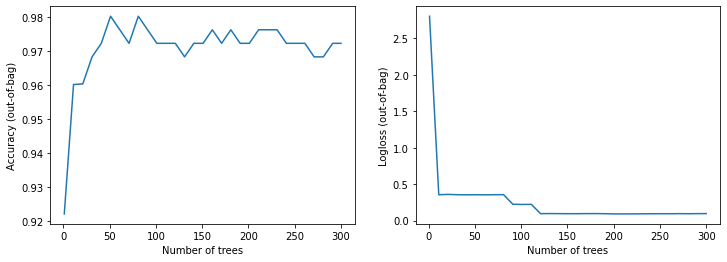

In [20]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

This dataset is small. You can see the model converging almost immediately.

Let's use TensorBoard:

In [21]:
# This cell start TensorBoard that can be slow.
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension

In [22]:
# Clear existing results (if any)
!rm -fr "/tmp/tensorboard_logs"

In [23]:
# Export the meta-data to tensorboard.
model_1.make_inspector().export_to_tensorboard("/tmp/tensorboard_logs")

In [ ]:
# docs_infra: no_execute
# Start a tensorboard instance.
%tensorboard --logdir "/tmp/tensorboard_logs"

<!-- <img class="tfo-display-only-on-site" src="images/beginner_tensorboard.png"/> -->


## Re-train the model with a different learning algorithm

The learning algorithm is defined by the model class. For
example, `tfdf.keras.RandomForestModel()` trains a Random Forest, while
`tfdf.keras.GradientBoostedTreesModel()` trains a Gradient Boosted Decision
Trees.

The learning algorithms are listed by calling `tfdf.keras.get_all_models()` or in the
[learner list](https://github.com/google/yggdrasil-decision-forests/manual/learners).

In [24]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

The description of the learning algorithms and their hyper-parameters are also available in the [API reference](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf) and builtin help:

In [25]:
# help works anywhere.
help(tfdf.keras.RandomForestModel)

# ? only works in ipython or notebooks, it usually opens on a separate panel.
tfdf.keras.RandomForestModel?

Help on class RandomForestModel in module tensorflow_decision_forests.keras:

class RandomForestModel(tensorflow_decision_forests.keras.wrappers.RandomForestModel)
 |  RandomForestModel(*args, **kwargs)
 |  
 |  Random Forest learning algorithm.
 |  
 |  A Random Forest (https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)
 |  is a collection of deep CART decision trees trained independently and without
 |  pruning. Each tree is trained on a random subset of the original training 
 |  dataset (sampled with replacement).
 |  
 |  The algorithm is unique in that it is robust to overfitting, even in extreme
 |  cases e.g. when there is more features than training examples.
 |  
 |  It is probably the most well-known of the Decision Forest training
 |  algorithms.
 |  
 |  Usage example:
 |  
 |  ```python
 |  import tensorflow_decision_forests as tfdf
 |  import pandas as pd
 |  
 |  dataset = pd.read_csv("project/dataset.csv")
 |  tf_dataset = tfdf.keras.pd_dataframe_to_tf_datase

## Using a subset of features

The previous example did not specify the features, so all the columns were used
as input feature (except for the label). The following example shows how to
specify input features.

In [26]:
feature_1 = tfdf.keras.FeatureUsage(name="bill_length_mm")
feature_2 = tfdf.keras.FeatureUsage(name="island")

all_features = [feature_1, feature_2]

# Note: This model is only trained with two features. It will not be as good as
# the one trained on all features.

model_2 = tfdf.keras.GradientBoostedTreesModel(
    features=all_features, exclude_non_specified_features=True)

model_2.compile(metrics=["accuracy"])
model_2.fit(x=train_ds, validation_data=test_ds)

print(model_2.evaluate(test_ds, return_dict=True))

1/4 [======>.......................] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4
[INFO kernel.cc:393] Number of examples: 252
[INFO kernel.cc:759] Dataset:
Number of records: 252
Number of columns: 3

Number of columns by type:
	CATEGORICAL: 2 (66.6667%)
	NUMERICAL: 1 (33.3333%)

Columns:

CATEGORICAL: 2 (66.6667%)
	1: "island" CATEGORICAL has-dict vocab-size:4 zero-ood-items most-frequent:"Biscoe" 126 (50%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:4 no-ood-item

NUMERICAL: 1 (33.3333%)
	0: "bill_length_mm" NUMERICAL num-nas:2 (0.793651%) mean:44.1884 min:33.1 max:59.6 sd:5.36528

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attribute value is obtained through tokenization.
	has-dict: The attribute is attached to a string dictionary e.g. a ca

4/4 [==============================] - 0s 92ms/step - val_loss: 0.0000e+00 - val_accuracy: 0.9674


1/2 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.9531

2/2 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9674


{'loss': 0.0, 'accuracy': 0.967391312122345}


**Note:** As expected, the accuracy is lower than previously.

**TF-DF** attaches a **semantics** to each feature. This semantics controls how
the feature is used by the model. The following semantics are currently supported:

-   **Numerical**: Generally for quantities or counts with full ordering. For
    example, the age of a person, or the number of items in a bag. Can be a
    float or an integer. Missing values are represented with float(Nan) or with
    an empty sparse tensor.
-   **Categorical**: Generally for a type/class in finite set of possible values
    without ordering. For example, the color RED in the set {RED, BLUE, GREEN}.
    Can be a string or an integer. Missing values are represented as "" (empty
    sting), value -2 or with an empty sparse tensor.
-   **Categorical-Set**: A set of categorical values. Great to represent
    tokenized text. Can be a string or an integer in a sparse tensor or a
    ragged tensor (recommended). The order/index of each item doesn't matter.

If not specified, the semantics is inferred from the representation type and shown in the training logs:

- int, float (dense or sparse) → Numerical semantics.
- str (dense or sparse) → Categorical semantics
- int, str (ragged) → Categorical-Set semantics

In some cases, the inferred semantics is incorrect. For example: An Enum stored as an integer is semantically categorical, but it will be detected as numerical. In this case, you should specify the semantic argument in the input. The `education_num` field of the Adult dataset is classical example.

This dataset doesn't contain such a feature. However, for the demonstration, we will make the model treat the `year` as a categorical feature:

In [27]:
%set_cell_height 300

feature_1 = tfdf.keras.FeatureUsage(name="year", semantic=tfdf.keras.FeatureSemantic.CATEGORICAL)
feature_2 = tfdf.keras.FeatureUsage(name="bill_length_mm")
feature_3 = tfdf.keras.FeatureUsage(name="sex")
all_features = [feature_1, feature_2, feature_3]

model_3 = tfdf.keras.GradientBoostedTreesModel(features=all_features, exclude_non_specified_features=True)
model_3.compile( metrics=["accuracy"])

with sys_pipes():
  model_3.fit(x=train_ds, validation_data=test_ds)

<IPython.core.display.Javascript object>

1/4 [======>.......................] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4
[INFO kernel.cc:393] Number of examples: 252
[INFO kernel.cc:759] Dataset:
Number of records: 252
Number of columns: 4

Number of columns by type:
	CATEGORICAL: 3 (75%)
	NUMERICAL: 1 (25%)

Columns:

CATEGORICAL: 3 (75%)
	1: "sex" CATEGORICAL num-nas:7 (2.77778%) has-dict vocab-size:3 zero-ood-items most-frequent:"male" 124 (50.6122%)
	2: "year" CATEGORICAL integerized vocab-size:2011 no-ood-item
	3: "__LABEL" CATEGORICAL integerized vocab-size:4 no-ood-item

NUMERICAL: 1 (25%)
	0: "bill_length_mm" NUMERICAL num-nas:2 (0.793651%) mean:44.1884 min:33.1 max:59.6 sd:5.36528

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attribute value is obtained through tokenization.
	has-

 axis_aligned_split {
    }
    internal {
      sorting_strategy: PRESORTED
    }
  }
  shrinkage: 0.1
  validation_set_ratio: 0.1
  early_stopping: VALIDATION_LOSS_INCREASE
  early_stopping_num_trees_look_ahead: 30
  l2_regularization: 0
  lambda_loss: 1
  mart {
  }
  adapt_subsample_for_maximum_training_duration: false
  l1_regularization: 0
  use_hessian_gain: false
  l2_regularization_categorical: 1
  apply_link_function: true
  compute_permutation_variable_importance: false
}

[INFO kernel.cc:790] Deployment config:
num_threads: 6

[INFO kernel.cc:817] Train model
[INFO gradient_boosted_trees.cc:404] Default loss set to MULTINOMIAL_LOG_LIKELIHOOD
[INFO gradient_boosted_trees.cc:1001] Training gradient boosted tree on 252 example(s) and 3 feature(s).
[INFO gradient_boosted_trees.cc:1044] 223 examples used for training and 29 examples used for validation


[INFO gradient_boosted_trees.cc:1426] 	num-trees:1 train-loss:0.967301 train-accuracy:0.865471 valid-loss:1.017016 valid-accuracy:0.655172


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.761793
[INFO gradient_boosted_trees.cc:229] Truncates the model to 45 tree(s) i.e. 15  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:15 valid-loss:0.761793 valid-accuracy:0.586207


[INFO kernel.cc:828] Export model in log directory: /tmp/tmpetvbj79i


[INFO kernel.cc:836] Save model in resources


[INFO kernel.cc:988] Loading model from path


[INFO decision_forest.cc:590] Model loaded with 45 root(s), 1933 node(s), and 3 input feature(s).
[INFO kernel.cc:848] Use fast generic engine


4/4 [==============================] - 0s 97ms/step - val_loss: 0.0000e+00 - val_accuracy: 0.7935


Note that `year` is in the list of CATEGORICAL features (unlike the first run).

## Hyper-parameters

**Hyper-parameters** are parameters of the training algorithm that impact
the quality of the final model. They are specified in the model class
constructor. The list of hyper-parameters is visible with the *question mark* colab command (e.g. `?tfdf.keras.GradientBoostedTreesModel`).

Alternatively, you can find them on the [TensorFlow Decision Forest Github](https://github.com/tensorflow/decision-forests/keras/wrappers_pre_generated.py) or the [Yggdrasil Decision Forest documentation](https://github.com/google/yggdrasil_decision_forests/documentation/learners).

The default hyper-parameters of each algorithm matches approximatively the initial publication paper. To ensure consistancy, new features and their matching hyper-parameters are always disable by default. That's why it is a good idea to tune your hyper-parameters.

In [28]:
# A classical but slighly more complex model.
model_6 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500, growing_strategy="BEST_FIRST_GLOBAL", max_depth=8)
model_6.fit(x=train_ds)

1/4 [======>.......................] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4
[INFO kernel.cc:393] Number of examples: 252
[INFO kernel.cc:759] Dataset:
Number of records: 252
Number of columns: 8

Number of columns by type:
	NUMERICAL: 5 (62.5%)
	CATEGORICAL: 3 (37.5%)

Columns:

NUMERICAL: 5 (62.5%)
	0: "bill_depth_mm" NUMERICAL num-nas:2 (0.793651%) mean:17.1936 min:13.2 max:21.5 sd:1.96763
	1: "bill_length_mm" NUMERICAL num-nas:2 (0.793651%) mean:44.1884 min:33.1 max:59.6 sd:5.36528
	2: "body_mass_g" NUMERICAL num-nas:2 (0.793651%) mean:4221 min:2700 max:6300 sd:811.125
	3: "flipper_length_mm" NUMERICAL num-nas:2 (0.793651%) mean:201.264 min:172 max:231 sd:14.0793
	6: "year" NUMERICAL mean:2008.05 min:2007 max:2009 sd:0.817297

CATEGORICAL: 3 (37.5%)
	4: "island" CATEGORICAL has-dict vocab-size:4 zero-ood-items most-frequent:"Biscoe" 126 (50%)
	5: "sex" CATEGORICAL num-nas:7 (2.77778%) has-dict vocab-size:3 zero-ood-ite

4/4 [==============================] - 0s 119ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.15912
[INFO gradient_boosted_trees.cc:229] Truncates the model to 87 tree(s) i.e. 29  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:29 valid-loss:0.159120 valid-accuracy:0.965517
[INFO kernel.cc:828] Export model in log directory: /tmp/tmp0acspar2
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 87 root(s), 4853 node(s), and 7 input feature(s).
[INFO kernel.cc:848] Use fast generic engine


In [29]:
# A more complex, but possibly, more accurate model.
model_7 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500,
    growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=8,
    split_axis="SPARSE_OBLIQUE",
    categorical_algorithm="RANDOM",
    )
model_7.fit(x=train_ds)

1/4 [======>.......................] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4
[INFO kernel.cc:393] Number of examples: 252
[INFO kernel.cc:759] Dataset:
Number of records: 252
Number of columns: 8

Number of columns by type:
	NUMERICAL: 5 (62.5%)
	CATEGORICAL: 3 (37.5%)

Columns:

NUMERICAL: 5 (62.5%)
	0: "bill_depth_mm" NUMERICAL num-nas:2 (0.793651%) mean:17.1936 min:13.2 max:21.5 sd:1.96763
	1: "bill_length_mm" NUMERICAL num-nas:2 (0.793651%) mean:44.1884 min:33.1 max:59.6 sd:5.36528
	2: "body_mass_g" NUMERICAL num-nas:2 (0.793651%) mean:4221 min:2700 max:6300 sd:811.125
	3: "flipper_length_mm" NUMERICAL num-nas:2 (0.793651%) mean:201.264 min:172 max:231 sd:14.0793
	6: "year" NUMERICAL mean:2008.05 min:2007 max:2009 sd:0.817297

CATEGORICAL: 3 (37.5%)
	4: "island" CATEGORICAL has-dict vocab-size:4 zero-ood-items most-frequent:"Biscoe" 126 (50%)
	5: "sex" CATEGORICAL num-nas:7 (2.77778%) has-dict vocab-size:3 zero-ood-ite

4/4 [==============================] - 0s 82ms/step


[INFO gradient_boosted_trees.cc:2740] Early stop of the training because the validation loss does not decrease anymore. Best valid-loss: 0.166186
[INFO gradient_boosted_trees.cc:229] Truncates the model to 78 tree(s) i.e. 26  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:26 valid-loss:0.166186 valid-accuracy:0.965517
[INFO kernel.cc:828] Export model in log directory: /tmp/tmpv6yz6pmp
[INFO kernel.cc:836] Save model in resources
[INFO kernel.cc:988] Loading model from path
[INFO decision_forest.cc:590] Model loaded with 78 root(s), 3770 node(s), and 7 input feature(s).
[INFO kernel.cc:848] Use fast generic engine


As new training methods are published and implemented, combinaisons of hyper-parameters can emerge as good or almost-always-better than the default parameters. To avoid changing the default hyper-parameter values these good combinaisons are indexed and available as hyper-parameter templates.

For example, the `benchmark_rank1` template is the best combinaison on our internal benchmarks. Those templates are versioned to allow training configuration stability e.g. `benchmark_rank1@v1`.

In [30]:
# A good template of hyper-parameters.
model_8 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
model_8.fit(x=train_ds)

1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 38ms/step


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4
[INFO kernel.cc:393] Number of examples: 252
[INFO kernel.cc:759] Dataset:
Number of records: 252
Number of columns: 8

Number of columns by type:
	NUMERICAL: 5 (62.5%)
	CATEGORICAL: 3 (37.5%)

Columns:

NUMERICAL: 5 (62.5%)
	0: "bill_depth_mm" NUMERICAL num-nas:2 (0.793651%) mean:17.1936 min:13.2 max:21.5 sd:1.96763
	1: "bill_length_mm" NUMERICAL num-nas:2 (0.793651%) mean:44.1884 min:33.1 max:59.6 sd:5.36528
	2: "body_mass_g" NUMERICAL num-nas:2 (0.793651%) mean:4221 min:2700 max:6300 sd:811.125
	3: "flipper_length_mm" NUMERICAL num-nas:2 (0.793651%) mean:201.264 min:172 max:231 sd:14.0793
	6: "year" NUMERICAL mean:2008.05 min:2007 max:2009 sd:0.817297

CATEGORICAL: 3 (37.5%)
	4: "island" CATEGORICAL has-dict vocab-size:4 zero-ood-items most-frequent:"Biscoe" 126 (50%)
	5: "sex" CATEGORICAL num-nas:7 (2.77778%) has-dict vocab-size:3 zero-ood-ite

The available tempaltes are available with `predefined_hyperparameters`. Note that different learning algorithms have different templates, even if the name is similar.

In [31]:
# The hyper-parameter templates of the Gradient Boosted Tree model.
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())

[HyperParameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


## Feature Preprocessing

Pre-processing features is sometimes necessary to consume signals with complex
structures, to regularize the model or to apply transfer learning.
Pre-processing can be done in one of three ways:

1.  Preprocessing on the Pandas dataframe. This solution is easy to implement
    and generally suitable for experimentation. However, the
    pre-processing logic will not be exported in the model by `model.save()`.

2.  [Keras Preprocessing](https://keras.io/guides/preprocessing_layers/): While
    more complex than the previous solution, Keras Preprocessing is packaged in
    the model.

3.  [TensorFlow Feature Columns](https://www.tensorflow.org/tutorials/structured_data/feature_columns):
    This API is part of the TF Estimator library (!= Keras) and planned for
    deprecation. This solution is interesting when using existing preprocessing
    code.

Note: Using [TensorFlow Hub](https://www.tensorflow.org/hub)
pre-trained embedding is often, a great way to consume text and image with
TF-DF. For example, `hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")`. See the [Intermediate tutorial](intermediate_colab.ipynb) for more details.

In the next example, pre-process the `body_mass_g` feature into `body_mass_kg = body_mass_g / 1000`. The `bill_length_mm` is consumed without pre-processing. Note that such
monotonic transformations have generally no impact on decision forest models.

In [32]:
%set_cell_height 300

body_mass_g = tf.keras.layers.Input(shape=(1,), name="body_mass_g")
body_mass_kg = body_mass_g / 1000.0

bill_length_mm = tf.keras.layers.Input(shape=(1,), name="bill_length_mm")

raw_inputs = {"body_mass_g": body_mass_g, "bill_length_mm": bill_length_mm}
processed_inputs = {"body_mass_kg": body_mass_kg, "bill_length_mm": bill_length_mm}

# "preprocessor" contains the preprocessing logic.
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

# "model_4" contains both the pre-processing logic and the decision forest.
model_4 = tfdf.keras.RandomForestModel(preprocessing=preprocessor)
model_4.fit(x=train_ds)

model_4.summary()

<IPython.core.display.Javascript object>

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['island', 'bill_depth_mm', 'flipper_length_mm', 'sex', 'year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 16ms/step


Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          {'body_mass_kg': (None,   0         
                             1),                                 
                              'bill_length_mm': (None            
                             , 1)}                               
                                                                 
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (2):
	bill_length_mm
	body_mass_kg

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.        "__LABEL"  3.902486 ################
    2.   "body_mass_kg"  1.189670 ####
    3. "bill_length_mm"  0.085316 

Variable Importance: NUM_AS_ROOT:
    1. "bill_length_mm" 277.000000 ################
    2.  

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4
[INFO kernel.cc:393] Number of examples: 252
[INFO kernel.cc:759] Dataset:
Number of records: 252
Number of columns: 3

Number of columns by type:
	NUMERICAL: 2 (66.6667%)
	CATEGORICAL: 1 (33.3333%)

Columns:

NUMERICAL: 2 (66.6667%)
	0: "bill_length_mm" NUMERICAL num-nas:2 (0.793651%) mean:44.1884 min:33.1 max:59.6 sd:5.36528
	1: "body_mass_kg" NUMERICAL num-nas:2 (0.793651%) mean:4.221 min:2.7 max:6.3 sd:0.811125

CATEGORICAL: 1 (33.3333%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:4 no-ood-item

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attribute value is obtained through tokenization.
	has-dict: The attribute is attached to a string dictionary e.g. a categor

The following example re-implements the same logic using TensorFlow Feature
Columns.

In [33]:
def g_to_kg(x):
  return x / 1000

feature_columns = [
    tf.feature_column.numeric_column("body_mass_g", normalizer_fn=g_to_kg),
    tf.feature_column.numeric_column("bill_length_mm"),
]

preprocessing = tf.keras.layers.DenseFeatures(feature_columns)

model_5 = tfdf.keras.RandomForestModel(preprocessing=preprocessing)
model_5.compile(metrics=["accuracy"])
model_5.fit(x=train_ds)

1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 16ms/step


[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 4
[INFO kernel.cc:393] Number of examples: 252
[INFO kernel.cc:759] Dataset:
Number of records: 252
Number of columns: 3

Number of columns by type:
	NUMERICAL: 2 (66.6667%)
	CATEGORICAL: 1 (33.3333%)

Columns:

NUMERICAL: 2 (66.6667%)
	0: "dense_features/concat:0.0" NUMERICAL num-nas:2 (0.793651%) mean:44.1884 min:33.1 max:59.6 sd:5.36528
	1: "dense_features/concat:0.1" NUMERICAL num-nas:2 (0.793651%) mean:4.221 min:2.7 max:6.3 sd:0.811125

CATEGORICAL: 1 (33.3333%)
	2: "__LABEL" CATEGORICAL integerized vocab-size:4 no-ood-item

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attribute value is obtained through tokenization.
	has-dict: The attribute is attached to a string d

## Training a regression model

The previous example trains a classification model (TF-DF does not differentiate
between binary classification and multi-class classification). In the next
example, train a regression model on the
[Abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone). The
objective of this dataset is to predict the number of shell's rings of an
abalone.

**Note:** The csv file is assembled by appending UCI's header and data files. No preprocessing was applied.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/LivingAbalone.JPG/800px-LivingAbalone.JPG" width="200"/></center>

In [34]:
# Download the dataset.
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/abalone_raw.csv -O /tmp/abalone.csv

dataset_df = pd.read_csv("/tmp/abalone.csv")
print(dataset_df.head(3))

  Type  LongestShell  Diameter  Height  WholeWeight  ShuckedWeight  \
0    M         0.455     0.365   0.095       0.5140         0.2245   
1    M         0.350     0.265   0.090       0.2255         0.0995   
2    F         0.530     0.420   0.135       0.6770         0.2565   

   VisceraWeight  ShellWeight  Rings  
0         0.1010         0.15     15  
1         0.0485         0.07      7  
2         0.1415         0.21      9  


In [35]:
# Split the dataset into a training and testing dataset.
train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Name of the label column.
label = "Rings"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

2896 examples in training, 1281 examples for testing.


/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core.py:1612: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [36]:
%set_cell_height 300

# Configure the model.
model_7 = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

# Optional.
model_7.compile(metrics=["mse"])

# Train the model.
with sys_pipes():
  model_7.fit(x=train_ds)

<IPython.core.display.Javascript object>

 1/46 [..............................] - ETA: 4s

25/46 [===============>..............] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 46
[INFO kernel.cc:393] Number of examples: 2896
[INFO kernel.cc:759] Dataset:
Number of records: 2896
Number of columns: 9

Number of columns by type:
	NUMERICAL: 8 (88.8889%)
	CATEGORICAL: 1 (11.1111%)

Columns:

NUMERICAL: 8 (88.8889%)
	0: "Diameter" NUMERICAL mean:0.40852 min:0.055 max:0.63 sd:0.0990864
	1: "Height" NUMERICAL mean:0.140059 min:0 max:1.13 sd:0.04324
	2: "LongestShell" NUMERICAL mean:0.525167 min:0.075 max:0.8 sd:0.120085
	3: "ShellWeight" NUMERICAL mean:0.240438 min:0.0015 max:1.005 sd:0.139656
	4: "ShuckedWeight" NUMERICAL mean:0.362275 min:0.001 max:1.488 sd:0.222695
	6: "VisceraWeight" NUMERICAL mean:0.18221 min:0.0005 max:0.76 sd:0.110215
	7: "WholeWeight" NUMERICAL mean:0.835914 min:0.002 max:2.8255 sd:0.493095
	8: "__LABEL" NUMERICAL mean:9.89572 min:1 max:29 sd:3.19208

CATEGORICAL: 1 (11.1111%)
	5: "Type" CATEGORICAL has-

[INFO random_forest.cc:628] Training of tree  1/300 (tree index:4) done rmse:2.65458


[INFO random_forest.cc:628] Training of tree  11/300 (tree index:9) done rmse:2.23049


[INFO random_forest.cc:628] Training of tree  21/300 (tree index:20) done rmse:2.16349


[INFO random_forest.cc:628] Training of tree  31/300 (tree index:28) done rmse:2.14447


[INFO random_forest.cc:628] Training of tree  41/300 (tree index:40) done rmse:2.1277


[INFO random_forest.cc:628] Training of tree  51/300 (tree index:50) done rmse:2.1135


[INFO random_forest.cc:628] Training of tree  61/300 (tree index:59) done rmse:2.10612


[INFO random_forest.cc:628] Training of tree  71/300 (tree index:69) done rmse:2.11104


[INFO random_forest.cc:628] Training of tree  81/300 (tree index:80) done rmse:2.11052


[INFO random_forest.cc:628] Training of tree  91/300 (tree index:92) done rmse:2.10818


[INFO random_forest.cc:628] Training of tree  101/300 (tree index:101) done rmse:2.10873


[INFO random_forest.cc:628] Training of tree  111/300 (tree index:108) done rmse:2.10696


[INFO random_forest.cc:628] Training of tree  121/300 (tree index:120) done rmse:2.10652


[INFO random_forest.cc:628] Training of tree  131/300 (tree index:129) done rmse:2.10811


[INFO random_forest.cc:628] Training of tree  141/300 (tree index:138) done rmse:2.10587


[INFO random_forest.cc:628] Training of tree  151/300 (tree index:153) done rmse:2.10578


[INFO random_forest.cc:628] Training of tree  161/300 (tree index:159) done rmse:2.10376


[INFO random_forest.cc:628] Training of tree  171/300 (tree index:169) done rmse:2.10388


[INFO random_forest.cc:628] Training of tree  181/300 (tree index:179) done rmse:2.1034


[INFO random_forest.cc:628] Training of tree  191/300 (tree index:189) done rmse:2.10272


[INFO random_forest.cc:628] Training of tree  201/300 (tree index:202) done rmse:2.10077


[INFO random_forest.cc:628] Training of tree  211/300 (tree index:211) done rmse:2.10126


[INFO random_forest.cc:628] Training of tree  221/300 (tree index:219) done rmse:2.10128


[INFO random_forest.cc:628] Training of tree  231/300 (tree index:229) done rmse:2.10058


[INFO random_forest.cc:628] Training of tree  241/300 (tree index:242) done rmse:2.10035


[INFO random_forest.cc:628] Training of tree  251/300 (tree index:250) done rmse:2.0999


[INFO random_forest.cc:628] Training of tree  261/300 (tree index:259) done rmse:2.10021


[INFO random_forest.cc:628] Training of tree  271/300 (tree index:269) done rmse:2.1001


[INFO random_forest.cc:628] Training of tree  281/300 (tree index:282) done rmse:2.09985


[INFO random_forest.cc:628] Training of tree  291/300 (tree index:292) done rmse:2.09927


[INFO random_forest.cc:628] Training of tree  300/300 (tree index:298) done rmse:2.09961
[INFO random_forest.cc:696] Final OOB metrics: rmse:2.09961


[INFO kernel.cc:828] Export model in log directory: /tmp/tmpceztfba5


[INFO kernel.cc:836] Save model in resources


[INFO kernel.cc:988] Loading model from path


[INFO decision_forest.cc:590] Model loaded with 300 root(s), 259840 node(s), and 8 input feature(s).
[INFO kernel.cc:848] Use fast generic engine


46/46 [==============================] - 2s 36ms/step


In [37]:
# Evaluate the model on the test dataset.
evaluation = model_7.evaluate(test_ds, return_dict=True)

print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

 1/46 [..............................] - ETA: 4s - loss: 0.0000e+00 - mse: 2.8430

12/46 [======>.......................] - ETA: 0s - loss: 0.0000e+00 - mse: 3.1492

23/46 [==============>...............] - ETA: 0s - loss: 0.0000e+00 - mse: 2.0431

34/46 [=====================>........] - ETA: 0s - loss: 0.0000e+00 - mse: 1.9307

45/46 [============================>.] - ETA: 0s - loss: 0.0000e+00 - mse: 1.8583

46/46 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - mse: 1.8496


{'loss': 0.0, 'mse': 1.8496248722076416}

MSE: 1.8496248722076416
RMSE: 1.3600091441632447


## Training a ranking model

Finaly, after having trained a classification and a regression models, train a [ranking](https://en.wikipedia.org/wiki/Learning_to_rank) model.

The goal of a ranking is to **order** items by importance. The "value" of
relevance does not matter directly. Ranking a set of *documents* with regard to
a user *query* is an example of ranking problem: It is only important to get the right order, where the top documents matter more.

TF-DF expects for ranking datasets to be presented in a "flat" format. A
document+query dataset might look like that:

query | document_id | feature_1 | feature_2 | relevance/label
----- | ----------- | --------- | --------- | ---------------
cat   | 1           | 0.1       | blue      | 4
cat   | 2           | 0.5       | green     | 1
cat   | 3           | 0.2       | red       | 2
dog   | 4           | NA        | red       | 0
dog   | 5           | 0.2       | red       | 1
dog   | 6           | 0.6       | green     | 1

The *relevance/label* is a floating point numerical value between 0 and 5
(generally between 0 and 4) where 0 means "completely unrelated", 4 means "very
relevant" and 5 means "the same as the query".

Interestingly, decision forests are often good rankers, and many
state-of-the-art ranking models are decision forests.

In this example, use a sample of the
[LETOR3](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/#!letor-3-0)
dataset. More precisely, we want to download the `OHSUMED.zip` from [the LETOR3 repo](https://onedrive.live.com/?authkey=%21ACnoZZSZVfHPJd0&id=8FEADC23D838BDA8%21107&cid=8FEADC23D838BDA8). This dataset is stored in the
libsvm format, so we will need to convert it to csv.

In [38]:
%set_cell_height 200

archive_path = tf.keras.utils.get_file("letor.zip",
  "https://download.microsoft.com/download/E/7/E/E7EABEF1-4C7B-4E31-ACE5-73927950ED5E/Letor.zip",
  extract=True)

# Path to the train and test dataset using libsvm format.
raw_dataset_path = os.path.join(os.path.dirname(archive_path),"OHSUMED/Data/All/OHSUMED.txt")

<IPython.core.display.Javascript object>

   16384/61824018 [..............................] - ETA: 16s

 2105344/61824018 [>.............................] - ETA: 1s 

 3162112/61824018 [>.............................] - ETA: 2s

 4849664/61824018 [=>............................] - ETA: 1s

13549568/61824018 [=====>........................] - ETA: 0s

15532032/61824018 [======>.......................] - ETA: 0s

16572416/61824018 [=======>......................] - ETA: 0s

25174016/61824018 [===========>..................] - ETA: 0s

26230784/61824018 [===========>..................] - ETA: 0s

27009024/61824018 [============>.................] - ETA: 0s

35659776/61824018 [================>.............] - ETA: 0s

36765696/61824018 [================>.............] - ETA: 0s

37748736/61824018 [=================>............] - ETA: 0s

42639360/61824018 [===================>..........] - ETA: 0s

47202304/61824018 [=====================>........] - ETA: 0s

49127424/61824018 [======================>.......] - ETA: 0s

50593792/61824018 [=======================>......] - ETA: 0s

57425920/61824018 [==========================>...] - ETA: 0s

58466304/61824018 [===========================>..] - ETA: 0s

61825024/61824018 [==============================] - 1s 0us/step


61833216/61824018 [==============================] - 1s 0us/step


The dataset is stored as a .txt file in a specific format, so first convert it into a csv file.

In [39]:
def convert_libsvm_to_csv(src_path, dst_path):
  """Converts a libsvm ranking dataset into a flat csv file.
  
  Note: This code is specific to the LETOR3 dataset.
  """
  dst_handle = open(dst_path, "w")
  first_line = True
  for src_line in open(src_path,"r"):
    # Note: The last 3 items are comments.
    items = src_line.split(" ")[:-3]
    relevance = items[0]
    group = items[1].split(":")[1]
    features = [ item.split(":") for item in items[2:]]

    if first_line:
      # Csv header
      dst_handle.write("relevance,group," + ",".join(["f_" + feature[0] for feature in features]) + "\n")
      first_line = False
    dst_handle.write(relevance + ",g_" + group + "," + (",".join([feature[1] for feature in features])) + "\n")
  dst_handle.close()

# Convert the dataset.
csv_dataset_path="/tmp/ohsumed.csv"
convert_libsvm_to_csv(raw_dataset_path, csv_dataset_path)

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv(csv_dataset_path)

# Display the first 3 examples.
dataset_df.head(3)

,relevance,group,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25
0,2,g_1,3.0,2.079442,0.272727,0.261034,37.330565,11.431241,37.29975,1.138657,...,9.340024,24.808785,0.393091,57.416517,3.294893,25.0231,3.219799,-3.87098,-3.90273,-3.87512
1,0,g_1,3.0,2.079442,0.428571,0.400594,37.330565,11.431241,37.29975,1.814480,...,9.340024,24.808785,0.349205,43.240626,2.654724,23.4903,3.156588,-3.96838,-4.00865,-3.98670
2,2,g_1,0.0,0.000000,0.000000,0.000000,37.330565,11.431241,37.29975,0.000000,...,9.340024,24.808785,0.240319,25.816989,1.551342,15.8650,2.764115,-4.28166,-4.33313,-4.44161


In [40]:
train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Display the first 3 examples of the training dataset.
train_ds_pd.head(3)

11319 examples in training, 4821 examples for testing.


,relevance,group,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25
0,2,g_1,3.0,2.079442,0.272727,0.261034,37.330565,11.431241,37.29975,1.138657,...,9.340024,24.808785,0.393091,57.416517,3.294893,25.0231,3.219799,-3.87098,-3.90273,-3.87512
1,0,g_1,3.0,2.079442,0.428571,0.400594,37.330565,11.431241,37.29975,1.814480,...,9.340024,24.808785,0.349205,43.240626,2.654724,23.4903,3.156588,-3.96838,-4.00865,-3.98670
3,2,g_1,4.0,2.772589,0.333333,0.320171,37.330565,11.431241,37.29975,1.260808,...,9.340024,24.808785,0.111496,10.092426,0.649758,14.2778,2.658706,-4.77772,-4.73563,-4.86759


In this dataset, the `relevance` defines the ground-truth rank among rows of the same `group`.

In [41]:
# Name of the relevance and grouping columns.
relevance = "relevance"

ranking_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=relevance, task=tfdf.keras.Task.RANKING)
ranking_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=relevance, task=tfdf.keras.Task.RANKING)

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core.py:1612: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [42]:
%set_cell_height 400

model_8 = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.RANKING,
    ranking_group="group",
    num_trees=50)

with sys_pipes():
  model_8.fit(x=ranking_train_ds)

<IPython.core.display.Javascript object>

  1/177 [..............................] - ETA: 1:27

 13/177 [=>............................] - ETA: 0s  

 25/177 [===>..........................] - ETA: 0s

 37/177 [=====>........................] - ETA: 0s

 49/177 [=======>......................] - ETA: 0s

 61/177 [=========>....................] - ETA: 0s

 73/177 [===========>..................] - ETA: 0s

 86/177 [=============>................] - ETA: 0s

 98/177 [===============>..............] - ETA: 0s

110/177 [=================>............] - ETA: 0s

122/177 [===================>..........] - ETA: 0s

135/177 [=====================>........] - ETA: 0s

147/177 [=======================>......] - ETA: 0s

159/177 [=========================>....] - ETA: 0s

171/177 [===========================>..] - ETA: 0s

[INFO kernel.cc:736] Start Yggdrasil model training
[INFO kernel.cc:737] Collect training examples
[INFO kernel.cc:392] Number of batches: 177
[INFO kernel.cc:393] Number of examples: 11319


[INFO kernel.cc:759] Dataset:
Number of records: 11319
Number of columns: 27

Number of columns by type:
	NUMERICAL: 26 (96.2963%)
	HASH: 1 (3.7037%)

Columns:

NUMERICAL: 26 (96.2963%)
	1: "f_1" NUMERICAL mean:1.18217 min:0 max:9 sd:1.11541
	2: "f_10" NUMERICAL mean:3.99046 min:0 max:20.6046 sd:3.73218
	3: "f_11" NUMERICAL mean:4.60756 min:0 max:59 sd:4.77462
	4: "f_12" NUMERICAL mean:2.03091 min:0 max:9.75731 sd:1.64511
	5: "f_13" NUMERICAL mean:0.0487304 min:0 max:0.357143 sd:0.0479245
	6: "f_14" NUMERICAL mean:0.0476729 min:0 max:0.336056 sd:0.0463874
	7: "f_15" NUMERICAL mean:21.7471 min:7.51456 max:40.0616 sd:7.02527
	8: "f_16" NUMERICAL mean:6.91506 min:2.01684 max:13.5772 sd:2.23384
	9: "f_17" NUMERICAL mean:19.7598 min:9.0472 max:40.1808 sd:6.57407
	10: "f_18" NUMERICAL mean:0.202416 min:0 max:1.51088 sd:0.18941
	11: "f_19" NUMERICAL mean:20.8352 min:0 max:178.097 sd:20.9669
	12: "f_2" NUMERICAL mean:0.805272 min:0 max:4.56435 sd:0.746546
	13: "f_20" NUMERICAL mean:1.83596 min

[INFO gradient_boosted_trees.cc:1044] 10276 examples used for training and 1043 examples used for validation


[INFO gradient_boosted_trees_loss.cc:1547] Found 97 groups in 10276 examples.
[INFO gradient_boosted_trees_loss.cc:1547] Found 9 groups in 1043 examples.


[INFO gradient_boosted_trees.cc:1426] 	num-trees:1 train-loss:-0.348863 train-NDCG@5:0.348863 valid-loss:-0.271541 valid-NDCG@5:0.271541


[INFO gradient_boosted_trees.cc:1426] 	num-trees:50 train-loss:-0.607105 train-NDCG@5:0.607105 valid-loss:-0.404367 valid-NDCG@5:0.404367
[INFO gradient_boosted_trees.cc:229] Truncates the model to 21 tree(s) i.e. 21  iteration(s).
[INFO gradient_boosted_trees.cc:263] Final model num-trees:21 valid-loss:-0.459177 valid-NDCG@5:0.459177


[INFO kernel.cc:828] Export model in log directory: /tmp/tmpo_9lrcak


[INFO kernel.cc:836] Save model in resources


[INFO kernel.cc:988] Loading model from path


177/177 [==============================] - 2s 11ms/step


[INFO abstract_model.cc:993] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:848] Use fast generic engine


At this point, keras does not propose any ranking metrics. Instead, the training and validation (a GBDT uses a validation dataset) are shown in the training
logs. In this case the loss is `LAMBDA_MART_NDCG5`, and the final (i.e. at
the end of the training) NDCG (normalized discounted cumulative gain) is `0.510136` (see line `Final model valid-loss: -0.510136`).

Note that the NDCG is a value between 0 and 1. The larget the NDCG, the better
the model. For this reason, the loss to be -NDCG.

As before, the model can be analysed:

In [43]:
%set_cell_height 400

model_8.summary()

<IPython.core.display.Javascript object>

Model: "gradient_boosted_trees_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: RANKING
Label: "__LABEL"
Rank group: "__RANK_GROUP"

Input Features (25):
	f_1
	f_10
	f_11
	f_12
	f_13
	f_14
	f_15
	f_16
	f_17
	f_18
	f_19
	f_2
	f_20
	f_21
	f_22
	f_23
	f_24
	f_25
	f_3
	f_4
	f_5
	f_6
	f_7
	f_8
	f_9

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__RANK_GROUP"  4.580857 ################
    2.      "__LABEL"  4.580857 ################
    3.          "f_1"  4.571903 ###############
    4.          "f_2"  4.546650 ###############
    5.         "f_18"  4.538126 ###############
    6.         "f_14"  4.484272 ###############
    7.         "f_11"  4.446549 ###############
    8.          "f_7"  4.434940 ###############
    9.        